In [17]:
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.collections as clt
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import scipy.linalg

In [68]:
def waterfall(xs,zs,data,maxlines=300,spacial2d=False,**args):
    xs = np.array(xs)
    zs = np.array(zs)
    data = np.array(data)
    
    step = (zs.size+maxlines-1)//maxlines
    
    if "figsize" not in args: args["figsize"] = (9,6)
    fig = plt.figure(**args)
    
    ax = fig.gca(projection='3d')

    cc = lambda arg: mcolors.to_rgba(arg,alpha=0.6)
    
    zmin = zs[0]
    zmax = zs[-1]
    dmin = np.minimum(0,np.min(data))
    dmax = np.maximum(0,np.max(data))
    xmin = xs[0]
    xmax = xs[-1]

    if spacial2d:
        xx,zz = np.meshgrid(xs,zs)
        ax.plot_wireframe(xx,zz,data)#,rstride=10,cstride=10)
    else:
        verts = []
        for i in range(0,zs.size,step):
            v = np.vstack([xs,data[i]]).T
            v2 = np.vstack([ [(xs[-1],0)] , v[::-1], [(xs[0],0)] ])
            verts.append(v2)

        poly = clt.PolyCollection(verts,
            edgecolors=(0,0,0,.8),facecolors=(0,0,1,.15))
        ax.add_collection3d(poly, zs=zs[::step], zdir='y')
    
    ax.view_init(elev=60,azim=180+75)
    
    z_scale = 0.6
    scale=np.diag([1,1,z_scale,1.0])
    scale=scale*(1.0/np.max(scale))
    scale[3,3] = 1.0

    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), scale)

    ax.set_xlabel('x')
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylabel('y' if spacial2d else 't')
    ax.set_ylim3d(zmin,zmax)
    ax.set_zlabel('u')
    ax.set_zlim3d(dmin,dmax)

    plt.show()

# Program 27

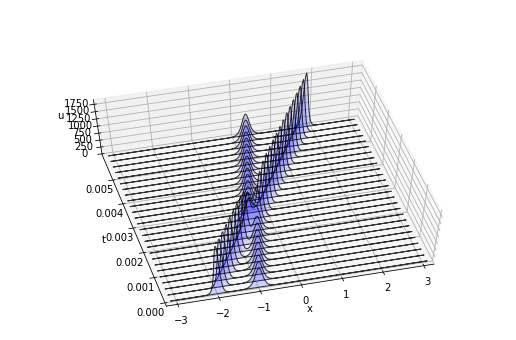

In [3]:
# Solve the KdV equation:
# u_t + u u_x + u_xxx = 0 on [-pi,pi] by FFT
# with integrating factor v = exp(-ik^3t)*uhat-

def program27(N,dt):
    # shortcuts
    sech = lambda x: 2/(np.exp(x)+np.exp(-x))
    fft = np.fft.fft
    ifft = np.fft.ifft

    # Set up grid and two-soliton initial data:
    x = (2*np.pi/N)*np.arange(-N/2,N/2)
    A = 25; B = 16;
    u = 3*A**2*sech(.5*(A*(x+2)))**2 + 3*B**2*sech(.5*(B*(x+1)))**2;

    v = np.fft.fft(u)
    k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])
    ik3 = 1j*k**3

    # Solve PDE and plot results:
    tmax = 0.006; nplt = np.floor((tmax/25)/dt); nmax = int(np.round(tmax/dt));
    udata = [u]; tdata = [0]
    for n in range(1,nmax+1):
        t = n*dt; g = -.5j*dt*k;
        # 4th order Runge-Kutta
        E = np.exp(dt*ik3/2); E2 = E**2;
        a = g*fft(np.real( ifft( v          ) )**2);
        b = g*fft(np.real( ifft( E*(v+a/2)  ) )**2);
        c = g*fft(np.real( ifft( E*v + b/2  ) )**2);
        d = g*fft(np.real( ifft( E2*v + E*c ) )**2);
        v = E2*v + (E2*a + 2*E*(b+c) + d)/6;
        if n % nplt == 0:
            u = np.real(ifft(v))
            udata.append(u); tdata.append(t)
    waterfall(x,tdata,udata)

program27(N=256,dt=.4/256**2)

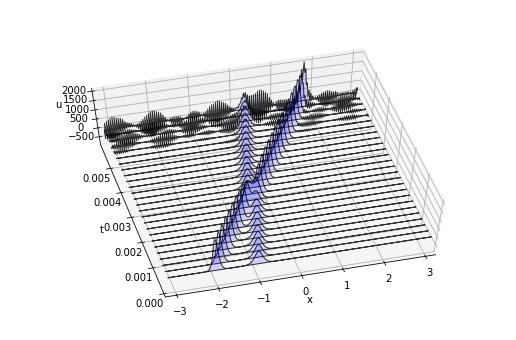

In [4]:
program27(N=256,dt=.427455/256**2)

/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in square
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply


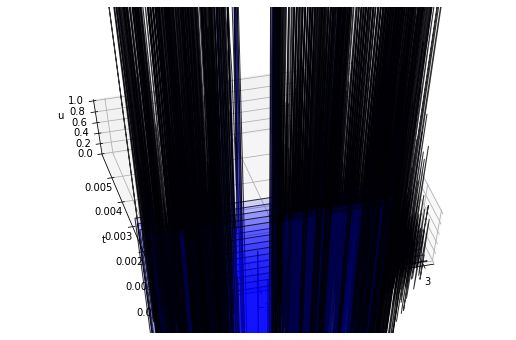

In [5]:
try: program27(N=256,dt=.45/256**2)
except: pass

# Program 34

In [6]:
def cheb(n):
    n += 1
    xs = np.cos(np.pi*np.arange(n)/(n-1))
    #
    deltas = xs.reshape(n,1)-xs.reshape(1,n)
    #
    ipj = np.arange(n).reshape((1,n))+np.arange(n).reshape((n,1))
    board = (-1.0)**ipj
    board[:,0] *= 0.5
    board[:,n-1] *= 0.5
    board[0,:] *= 2
    board[n-1,:] *= 2
    #
    d = board/(deltas+np.eye(n))
    res = d-np.diag(np.sum(d,axis=1))
    return res,xs

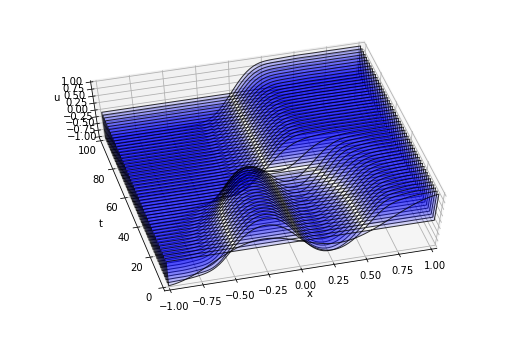

In [7]:
def program34(N=20,tmax=100,tplot=2):
    D,x = cheb(N); D2 = np.dot(D,D) # use full-size matrix
    D2[[0,N],:] = 0 # for convenience
    eps = 0.01; dt = min(0.01,50*N**-4.0/eps);
    t = 0; v = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
    
    # Solve PDE
    nplots = round(tmax/tplot);
    plotgap = round(tplot/dt); dt = tplot/plotgap;
    xx = np.arange(-1,1.001,0.025);
    vv = np.polyval(np.polyfit(x,v,N),xx)
    
    plotdata = np.vstack([[vv], np.zeros((nplots,len(xx)))]);
    tdata = [t];
    for i in range(1,nplots+1):
        for n in range(1,plotgap+1):
            t = t+dt
            v = v + dt*(eps*np.dot(D2,v-x) + v - v**3);
        vv = np.polyval(np.polyfit(x,v,N),xx);
        plotdata[i,:] = vv; tdata.append(t)
    
    # Plot results
    waterfall(xx,tdata,plotdata)

program34()

# Program 35

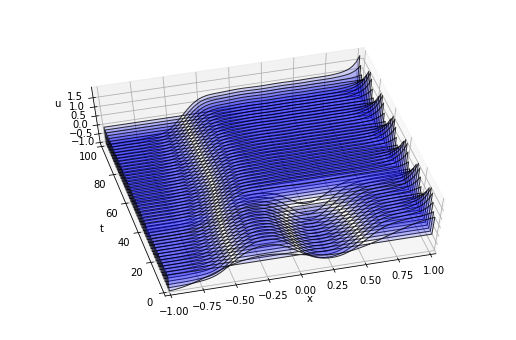

In [8]:
def program35(N=20,tmax=100,tplot=2):
    D,x = cheb(N); D2 = np.dot(D,D) # use full-size matrix
    D2[[0,N],:] = 0 # for convenience
    eps = 0.01; dt = min(0.01,50*N**-4.0/eps);
    t = 0; v = 0.53*x + 0.47*np.sin(-1.5*np.pi*x)
    
    # Solve PDE
    nplots = round(tmax/tplot);
    plotgap = round(tplot/dt); dt = tplot/plotgap;
    xx = np.arange(-1,1.001,0.025);
    vv = np.polyval(np.polyfit(x,v,N),xx)
    
    plotdata = np.vstack([[vv], np.zeros((nplots,len(xx)))]);
    tdata = [t];
    for i in range(1,nplots+1):
        for n in range(1,plotgap+1):
            t = t+dt
            v = v + dt*(eps*np.dot(D2,v-x) + v - v**3)
            v[0] = 1 + np.sin(t/5)**2
            v[-1] = -1
        vv = np.polyval(np.polyfit(x,v,N),xx);
        plotdata[i,:] = vv; tdata.append(t)
    
    # Plot results
    waterfall(xx,tdata,plotdata)

program35()

# Program 37

t=0.00


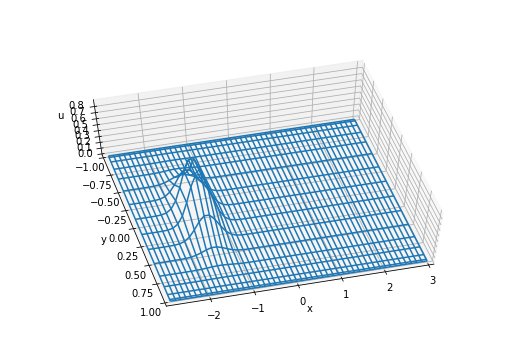

t=2.00


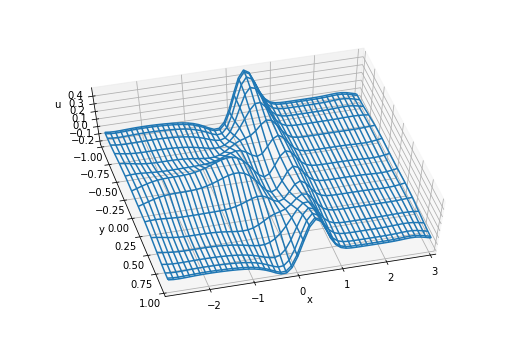

t=4.00


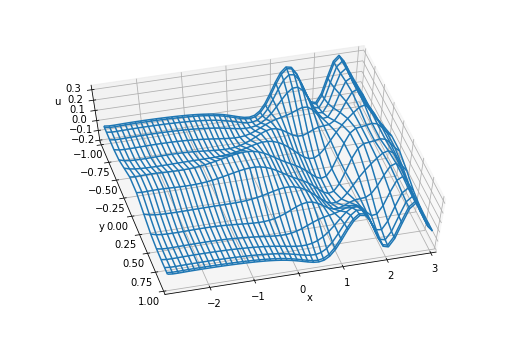

In [69]:
def program37():
    # 2D "wave tank" with Neumann BCs for |y|=1
    
    # x variable in [-A,A], Fourier:
    A = 3; Nx = 50; dx = 2*A/Nx; x = -A+dx*np.arange(1,Nx+1) #.T
    arr = .5*(-1)**np.arange(2,Nx+1)/np.sin((np.pi*dx/A)*np.arange(1,Nx)/2)**2
    D2x = (np.pi/A)**2*scipy.linalg.toeplitz(np.hstack([[-1/(3*(dx/A)**2)-1/6],arr]));
    
    # y variable in [-1,1], Chebyshev:
    Ny = 15; Dy,y = cheb(Ny); D2y = np.dot(Dy,Dy);
    aaa = -Dy[[0,Ny]][:,[0,Ny]]
    bbb = Dy[[0,Ny]][:,1:Ny]
    BC = np.linalg.solve(aaa,bbb);
    
    # Grid and initial data:
    dt = 5/(Nx+Ny**2); plotgap = round(2/dt); dt = 2/plotgap;
    xx,yy = np.meshgrid(x,y)
    vv = np.exp(-8*((xx+1.5)**2+yy**2))
    vvold = np.exp((-8*((xx+dt+1.5)**2+yy**2)))
    
    # Time-stepping by leap frog formula:
    for n in range(2*plotgap+1):
        t = n*dt
        if (n+.5)%plotgap<1:
            print("t=%.2f"%t)
            waterfall(x,y,vv,spacial2d=True)
        vvnew = 2*vv - vvold + dt**2*(np.dot(vv,D2x)+np.dot(D2y,vv))
        vvold = vv; vv = vvnew
        vv[[0,Ny]] = np.dot(BC,vv[1:Ny,:]) # Neumann BCs for |y|=1
program37()

# Program 36 (extra)

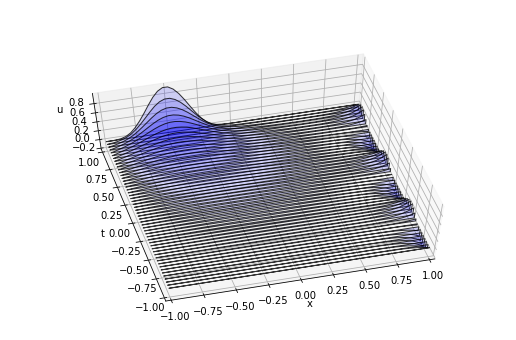

In [59]:
def program36(N=24):
    # Set up grid and 2D Laplacian, boundary points included:
    D,x = cheb(N); y = x
    xx,yy = np.meshgrid(x,y)
    D2 = np.dot(D,D)
    I = np.eye(N+1); L= np.kron(I,D2) + np.kron(D2,I)
    # Impose boundary conditions by replacing appropriate rows of L
    bi = np.flatnonzero(np.logical_or(np.abs(xx)==1,np.abs(yy)==1)) # boundary indexes (i)
    bx = np.nonzero(np.logical_or(np.abs(xx)==1,np.abs(yy)==1)) # boundary indexes (x,y)
    L[bi,:] = 0
    L[bi,bi] = 1 # not sure
    rhs = np.zeros(((N+1)**2,1))
    rhs[bi,0] = (yy[bx]==1)*(xx[bx]<0)*np.sin(np.pi*xx[bx])**4 + \
        .2*(xx[bx]==1)*np.sin(3*np.pi*yy[bx])
    # Solve Laplace equation, reshape to 2D, and plot
    u = np.linalg.solve(L,rhs)
    uu = u.reshape((N+1,N+1))
    xx,yy = np.meshgrid(x,y)
    f = scipy.interpolate.interp2d(xx,yy,uu,'cubic');
    xxx,yyy = np.arange(-1,1.0001,.04), np.arange(-1,1.0001,.04);
    uuu = f(xxx,yyy)
    waterfall(xxx,yyy,uuu)
    
    
program36()